In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplhep as hep
from iminuit import Minuit
from iminuit.cost import LeastSquares
import pickle
from ProcessDataFunctions import datTXT_to_DF
from ProcessDataFunctions import apply_pedestal_corrections
import uproot as ur
import matplotlib.colors as mcolors
import numpy as np
from scipy.optimize import curve_fit
from scipy.interpolate import UnivariateSpline
from scipy.signal import find_peaks
def configure_plotting():
    plt.rcParams['figure.facecolor'] = 'white'
    plt.rcParams['savefig.facecolor'] = 'white'
    plt.rcParams['savefig.bbox'] = 'tight'
    hep.style.use(hep.style.CMS)

In [2]:
input_file = "/Users/seanbp/Documents/Data/GenII_Prototype_Data/JLab/Cosmic/Run1_list.txt"
cosmic_df1 = datTXT_to_DF(input_file)
input_file = "/Users/seanbp/Documents/Data/GenII_Prototype_Data/JLab/Cosmic/Run2_list.txt"
cosmic_df2 = datTXT_to_DF(input_file)
cosmic_df = pd.concat([cosmic_df1, cosmic_df2], ignore_index=True)

In [3]:
ped_dict = pd.read_pickle("Ped_63_60.pkl")
cosmic_df = apply_pedestal_corrections(cosmic_df, ped_dict, threshold=3)

In [4]:
def linear(x, m, b):
    return m * x + b

def plot_combined_gain(df):
    configure_plotting()

    hg = df["HG_ped_corr"].values
    lg = df["LG_ped_corr"].values

    # Filter non-zero entries
    mask = (hg > 0) & (lg > 0)
    hg = hg[mask]
    lg = lg[mask]

    # Plot
    fig, ax = plt.subplots(figsize=(15, 15))
    h = ax.hist2d(
        lg, hg,
        bins=100,
        range=[(0.1, 800), (0.1, 7500)],
        cmap="viridis",
        norm=mcolors.LogNorm()
    )

    cbar = plt.colorbar(h[3], ax=ax)
    cbar.set_label("Counts")

    x_fit = np.linspace(0, 800, 200)
    y_fit = linear(x_fit, 11, -300)
    ax.plot(x_fit, y_fit, color="red")

    ax.set_xlabel("LG")
    ax.set_ylabel("HG")
    ax.set_title("Combined HG vs LG")

    fig.tight_layout()

    plt.show()

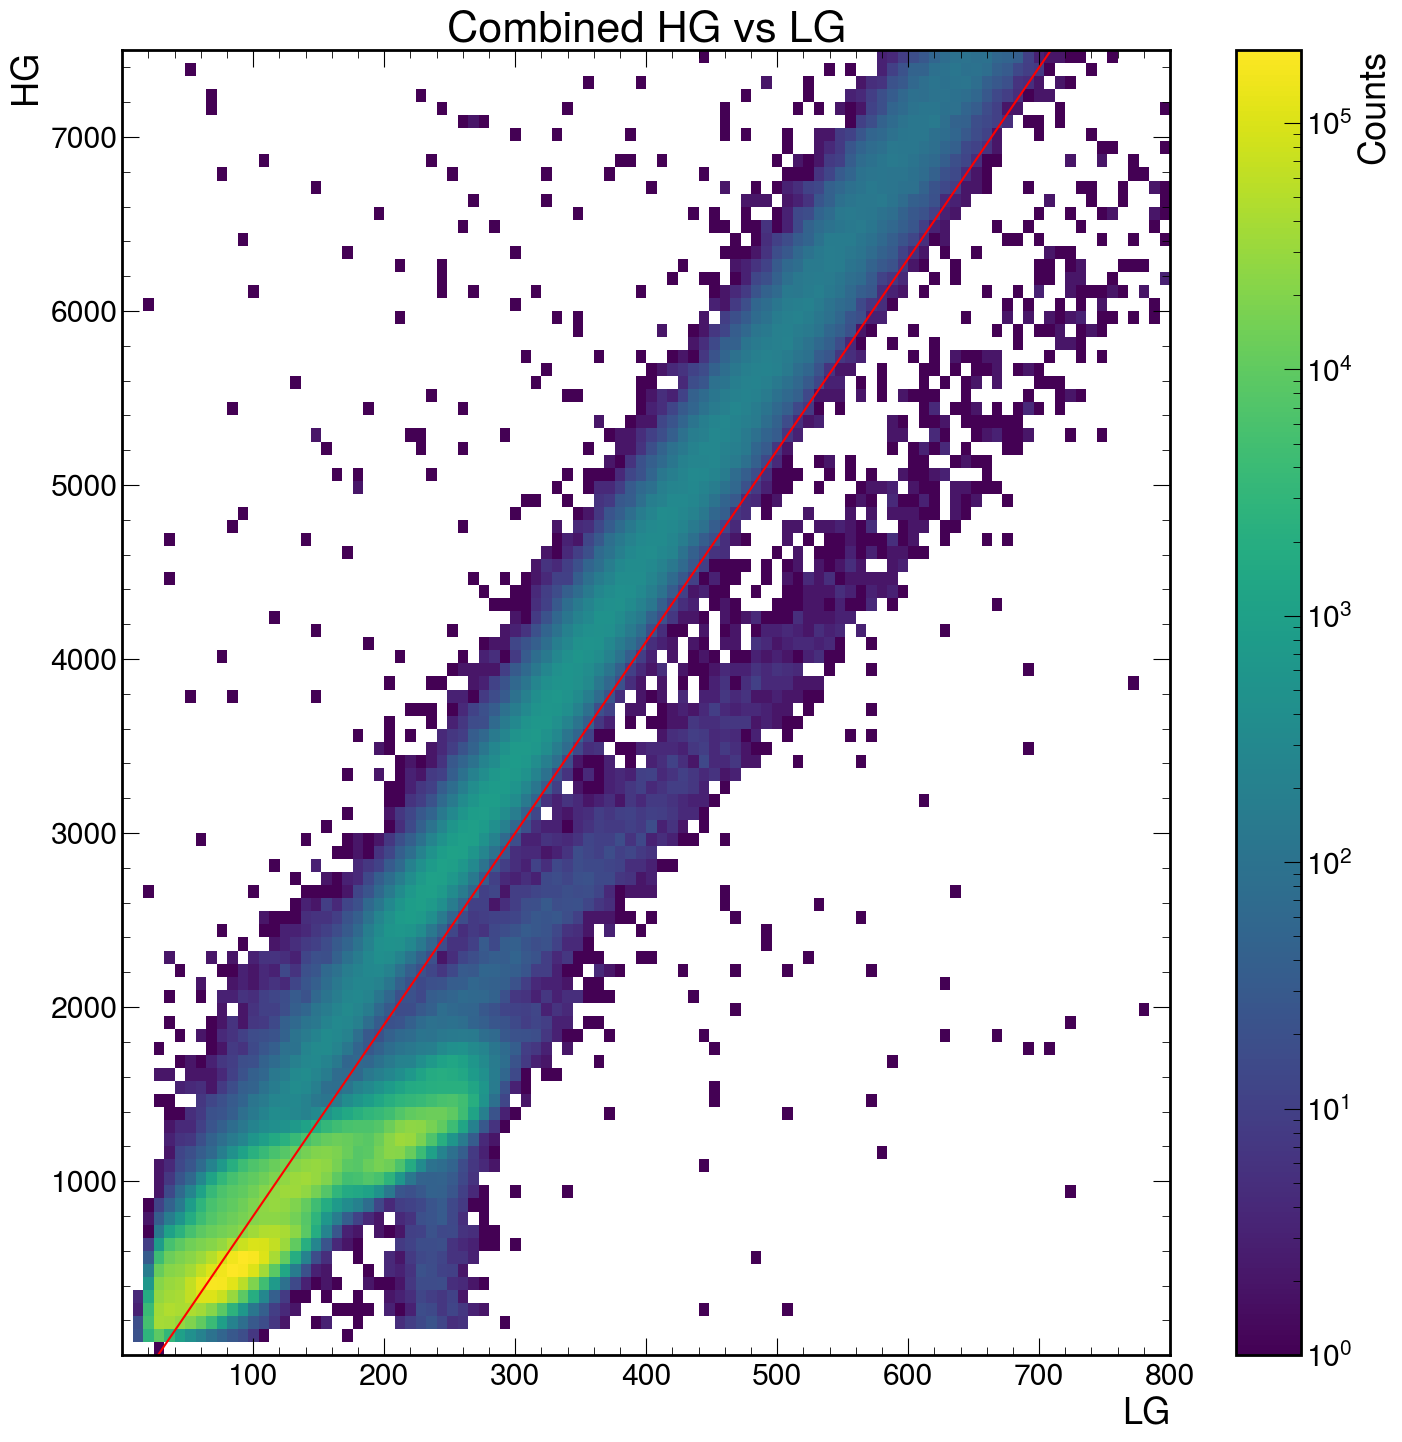

In [5]:
plot_combined_gain(cosmic_df)

In [6]:
def plot_mip_peaks_grid_for_caen(df, caen_unit, value_column='HG_ped_corr', min_peak_x=2000):
    # Select relevant rows
    caen_df = df[df["CAEN"] == caen_unit].copy()
    
    # Filter only the points above the threshold line y = 11x - 300
    caen_df = caen_df[caen_df["HG_ped_corr"] > 11 * caen_df["LG_ped_corr"] - 300]

    caen_df["channel"] = caen_df["CAEN"] * 64 + caen_df["CAEN_ch"]
    channels = sorted(caen_df["channel"].unique())
    
    num_cols = 8
    num_rows = 8
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 20), constrained_layout=True, sharey=True)
    axes = axes.flatten()
    
    num_channels = 64

    for i in range(num_channels):
        ax = axes[i]
        channel_data = caen_df[caen_df["channel"] == i + (caen_unit*64)][value_column].dropna()
        data = channel_data[channel_data > 0].values
        
        if len(data) < 100:

            mip_peaks.append(0)
            continue

        counts, bin_edges = np.histogram(data, bins=20, range=[0, 8000])
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        errors = np.sqrt(counts)
        mask = counts < 2000
        bin_centers = bin_centers[mask]
        errors = errors[mask]
        counts = counts[mask]

        if len(bin_centers) < 4:

            mip_peaks.append(0)
            continue

        # Plot raw data
        ax.errorbar(bin_centers, counts, yerr=errors, fmt='o', label=f"Ch {i}")

        # Fit spline
        spline = UnivariateSpline(bin_centers, counts, s=500, k=3)
        interp_x = np.linspace(bin_centers[0], bin_centers[-1], 10000)
        interp_y = spline(interp_x)

        # Find MIP peak
        peaks, properties = find_peaks(interp_y, height=0)
        peak_positions = interp_x[peaks]
        peak_heights = properties['peak_heights']

        valid_indices = [j for j, x in enumerate(peak_positions) if x > min_peak_x]
        if valid_indices:
            max_idx = valid_indices[np.argmax([peak_heights[j] for j in valid_indices])]
            mip_peak = peak_positions[max_idx]
        else:
            mip_peak = 0

        mip_peaks.append(mip_peak)

        ax.axvline(x=mip_peak, color='red', linestyle='--', lw=1)
        ax.plot(interp_x, interp_y, linestyle="--", color='gray')
        ax.set_yscale('log')
        ax.set_ylim(1, 10e4)
        ax.legend()
        
        if i % num_cols == 0:
            ax.set_ylabel("Counts")
        else:
            ax.set_yticks([])
        if i >= 56:
            ax.set_xlabel(value_column)
        else:
            ax.set_xticks([])
            
    plt.tight_layout(pad=0.0)
    plt.tight_layout(rect=[0, 0, 1.5, 1])
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

/var/folders/78/mghq7lpd3rbcbtn434kbwgdw0000gn/T/ipykernel_2559/2961455571.py:78: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=0.0)


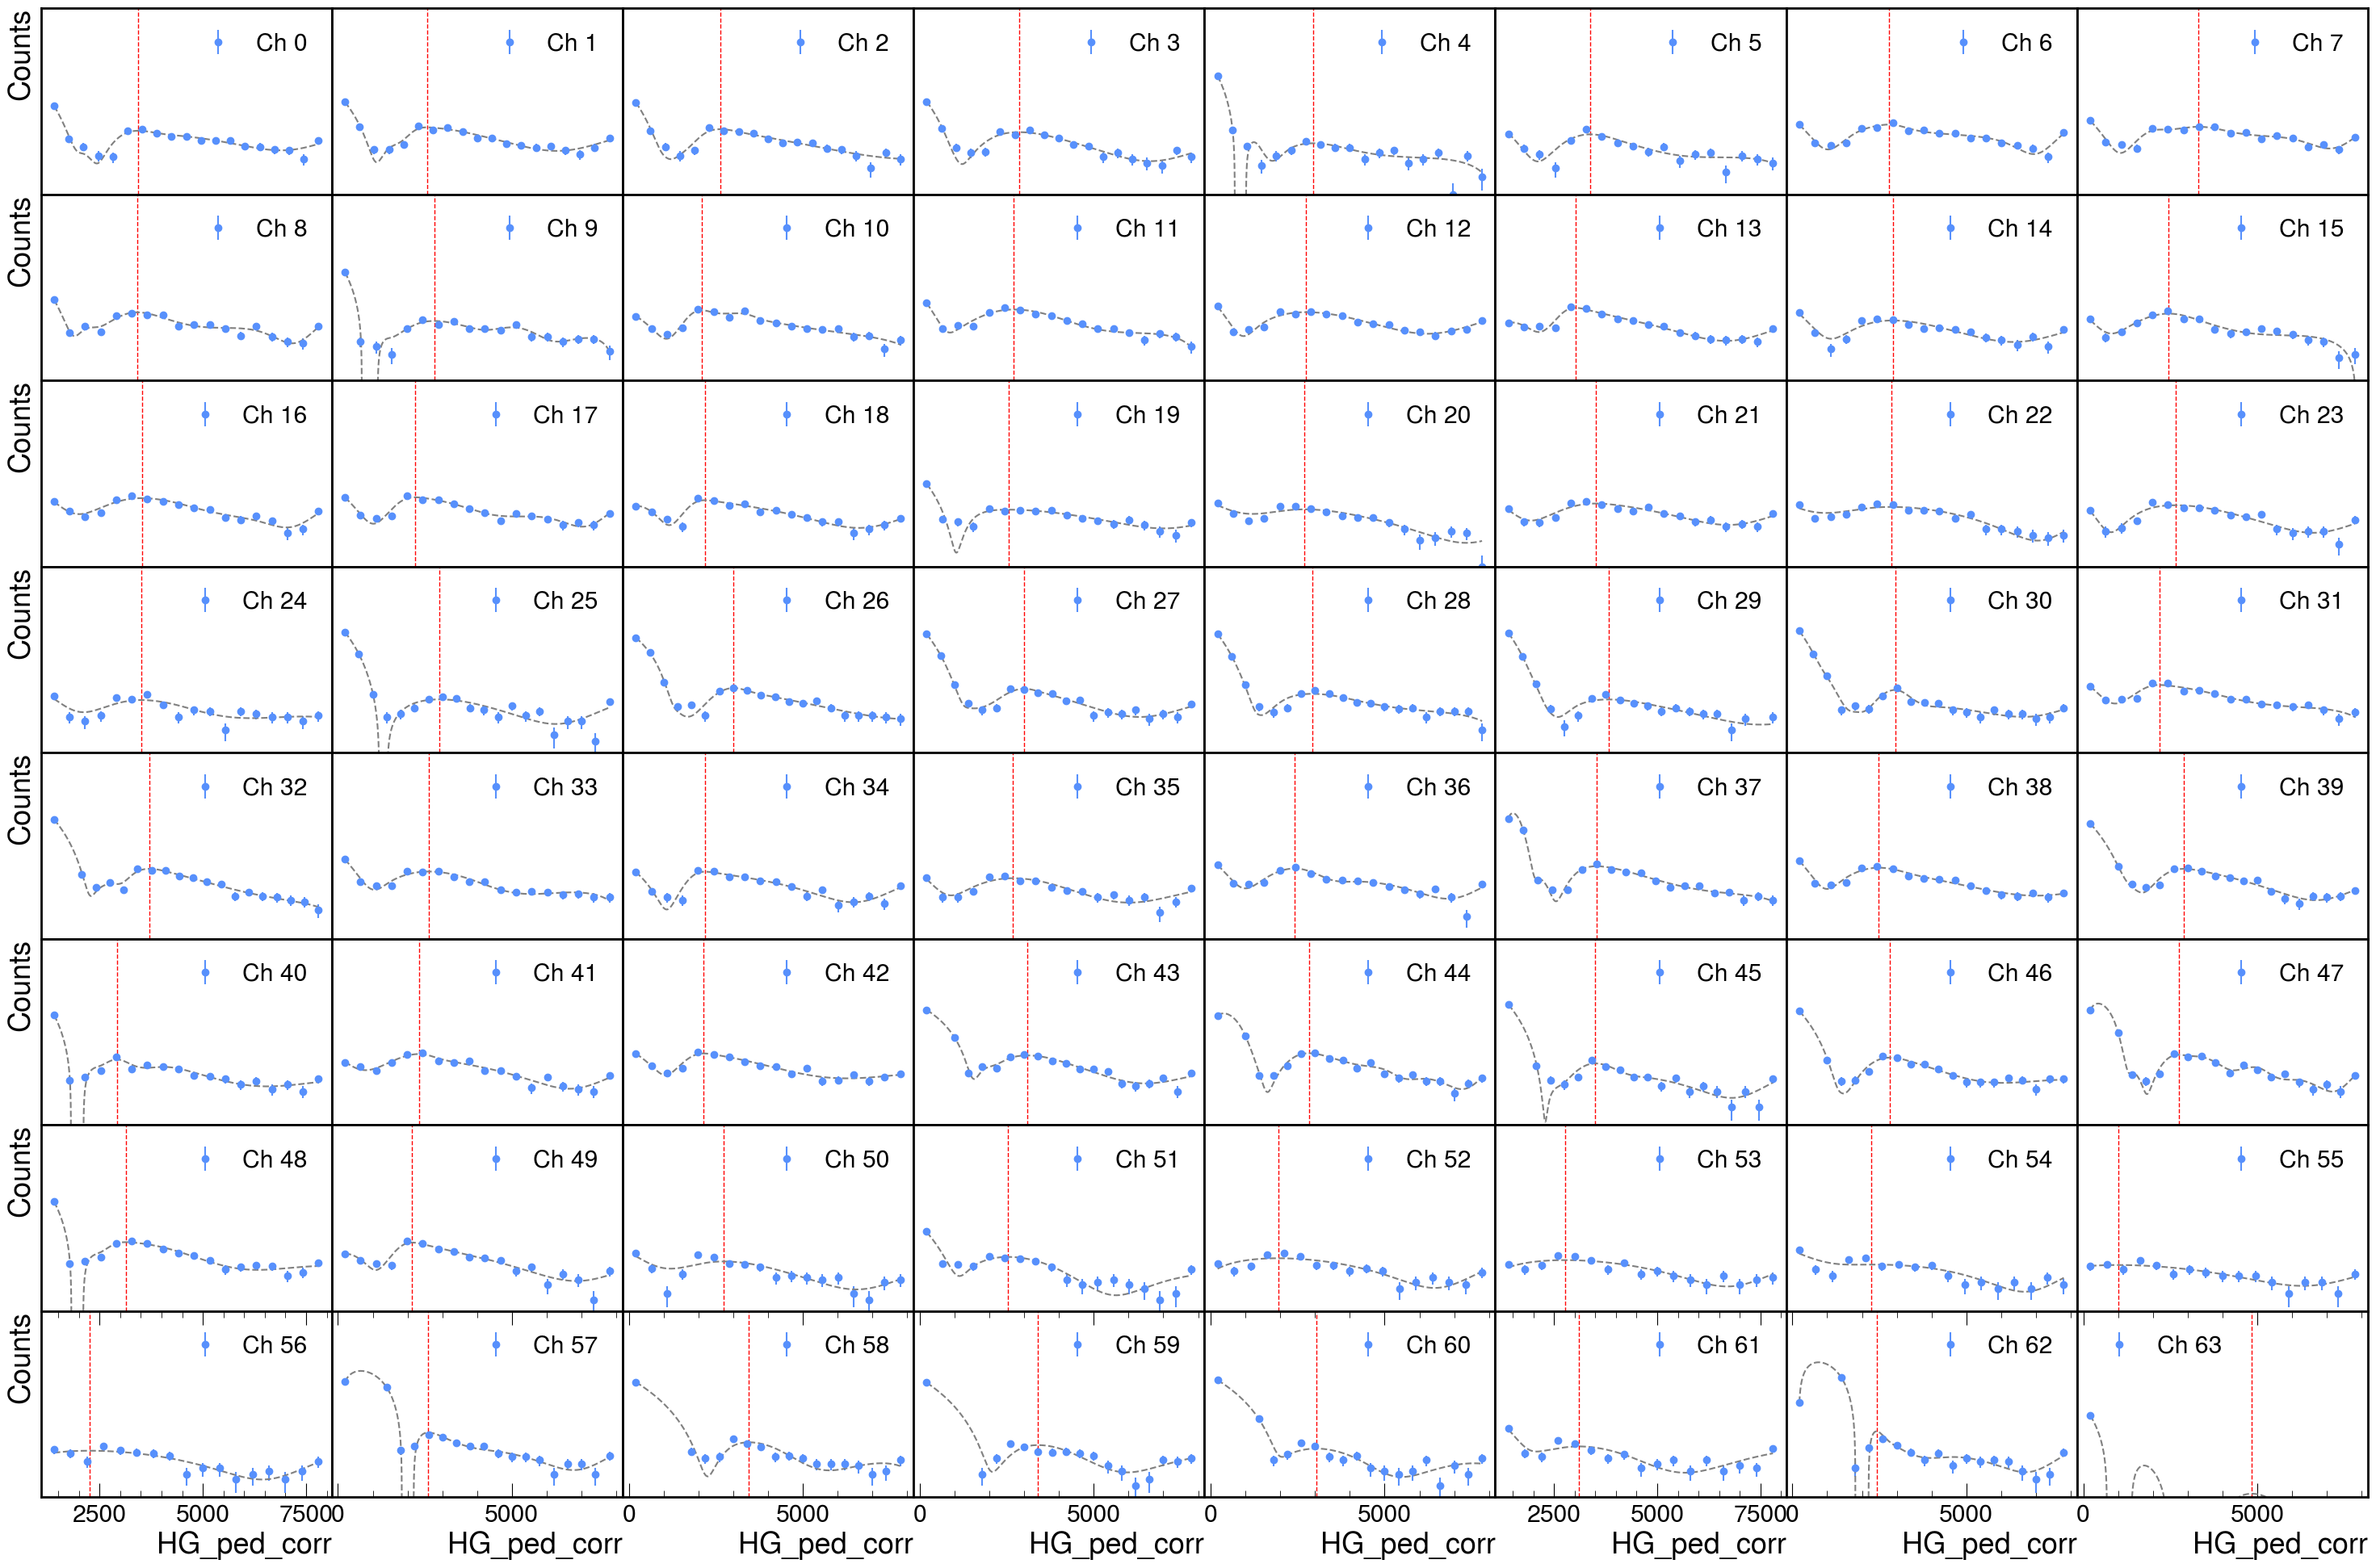

/var/folders/78/mghq7lpd3rbcbtn434kbwgdw0000gn/T/ipykernel_2559/2961455571.py:78: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=0.0)


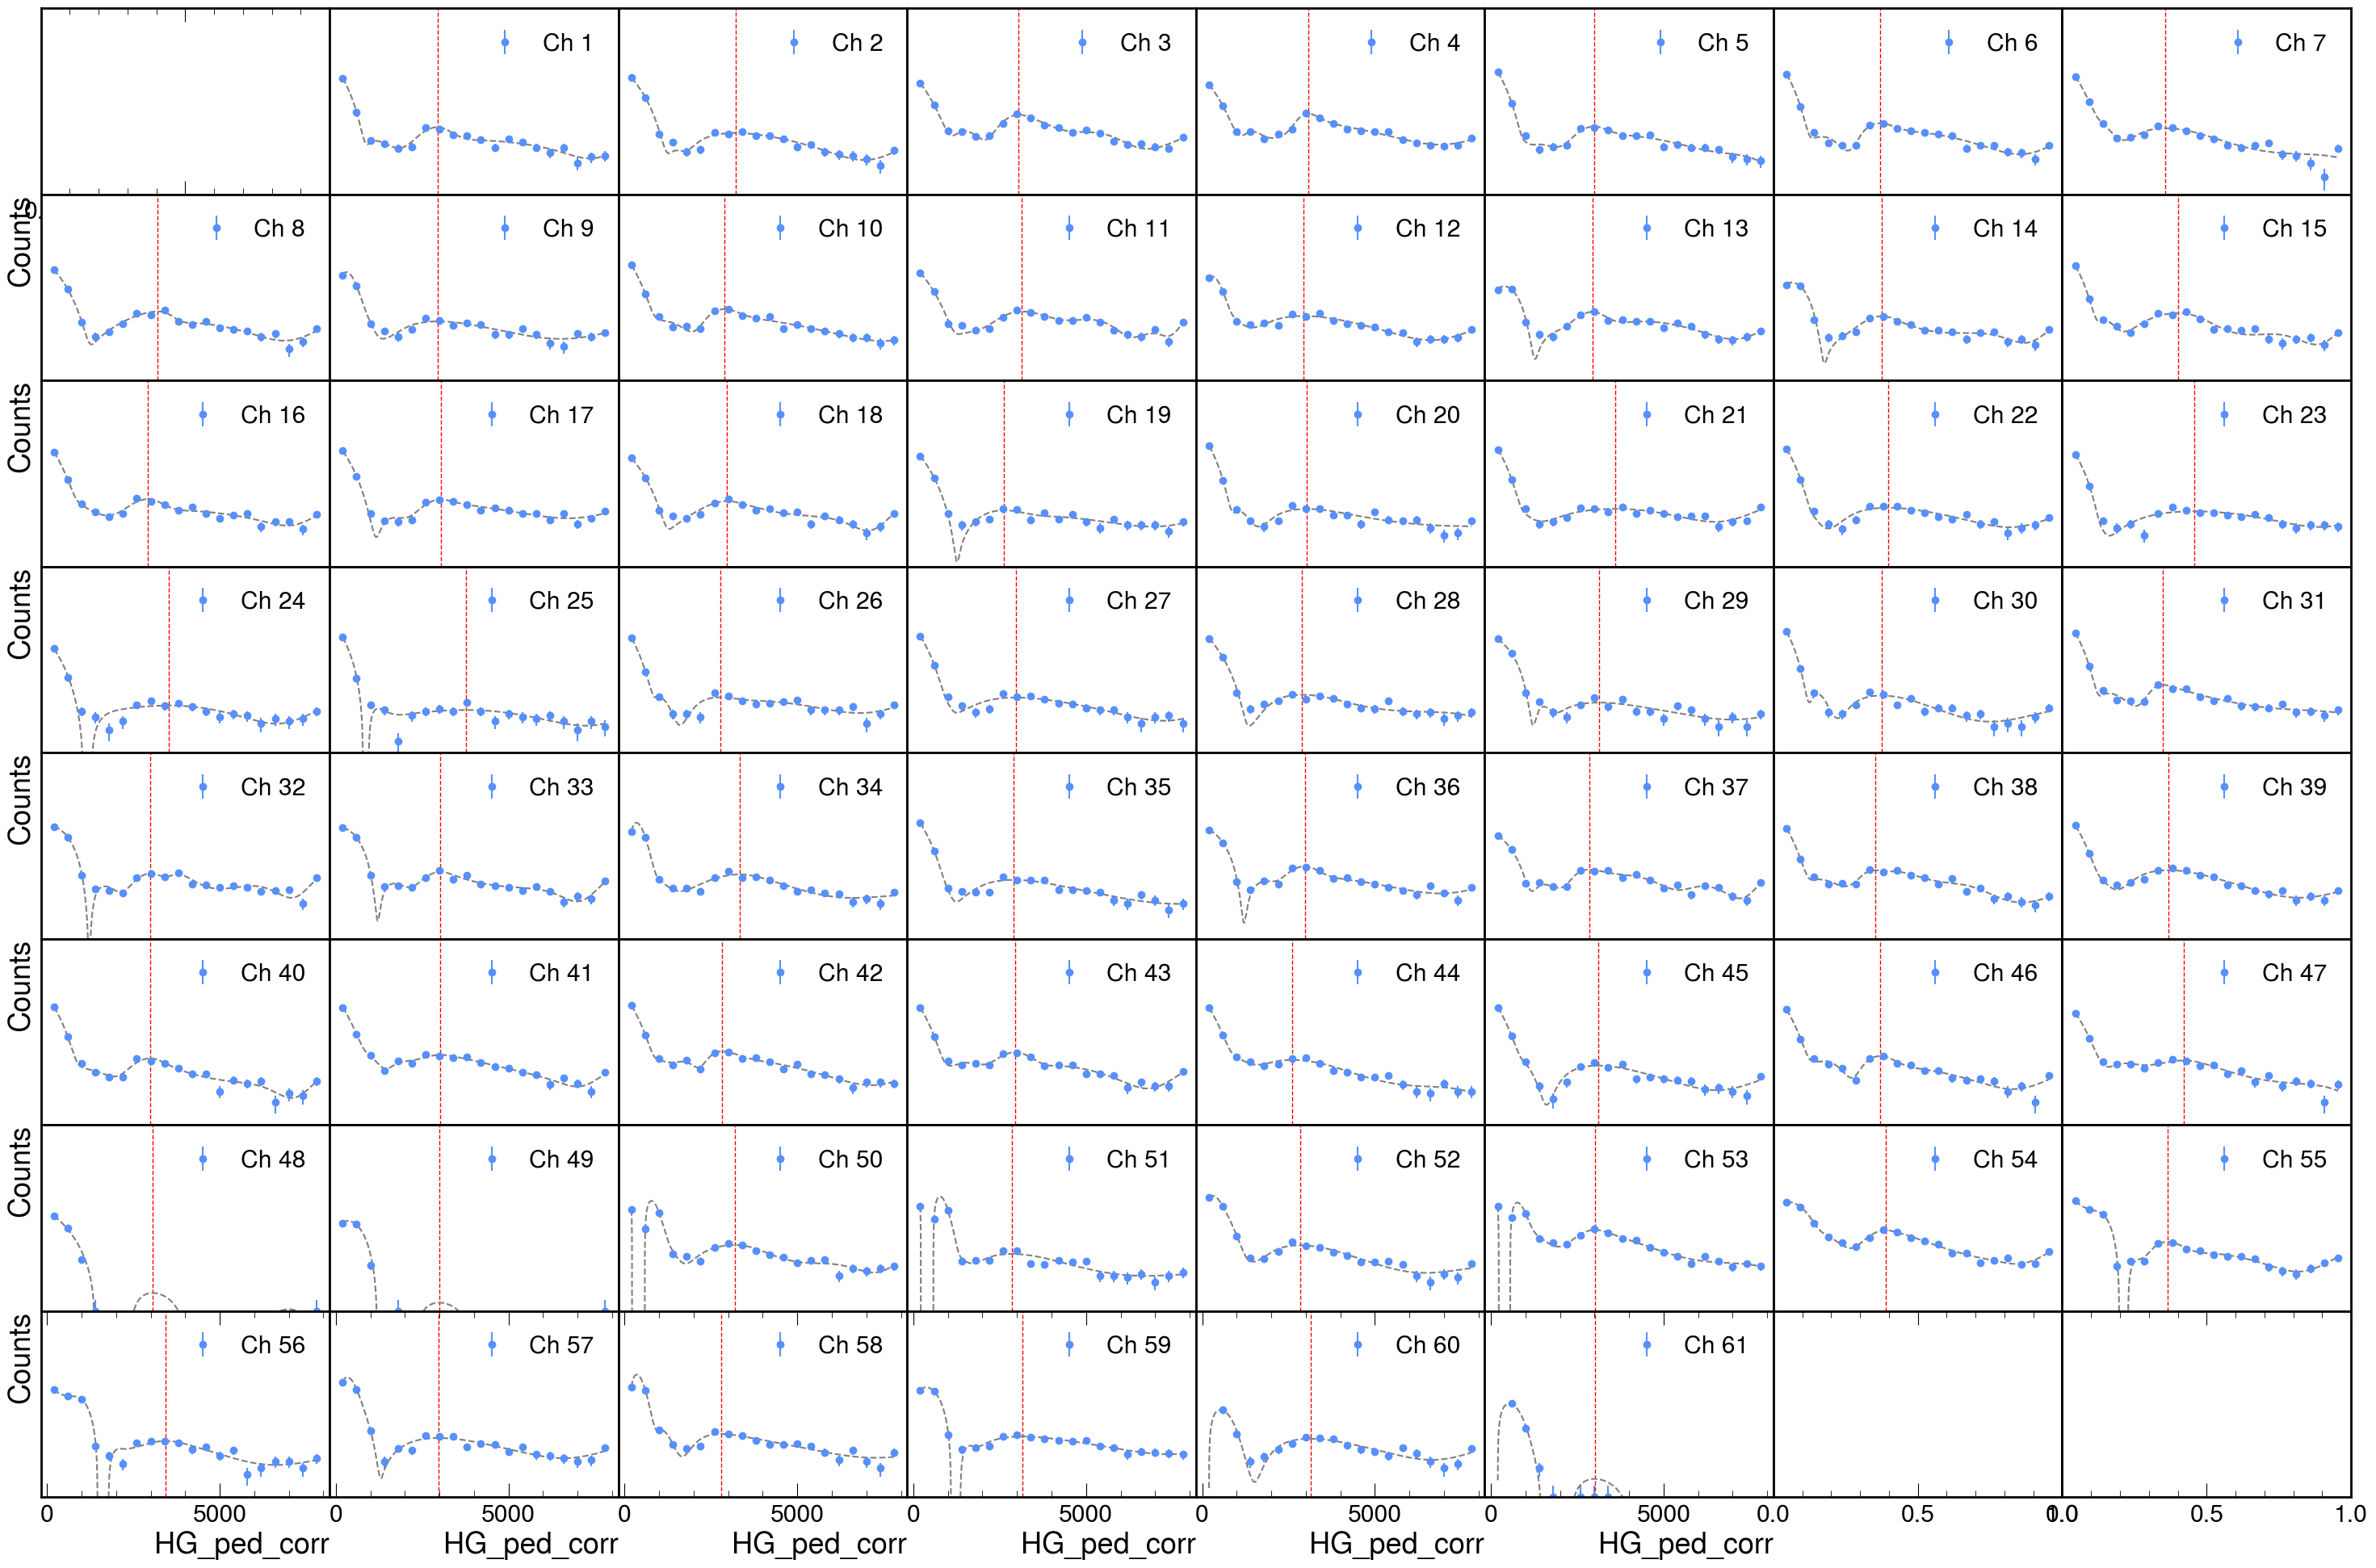

/var/folders/78/mghq7lpd3rbcbtn434kbwgdw0000gn/T/ipykernel_2559/2961455571.py:78: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=0.0)


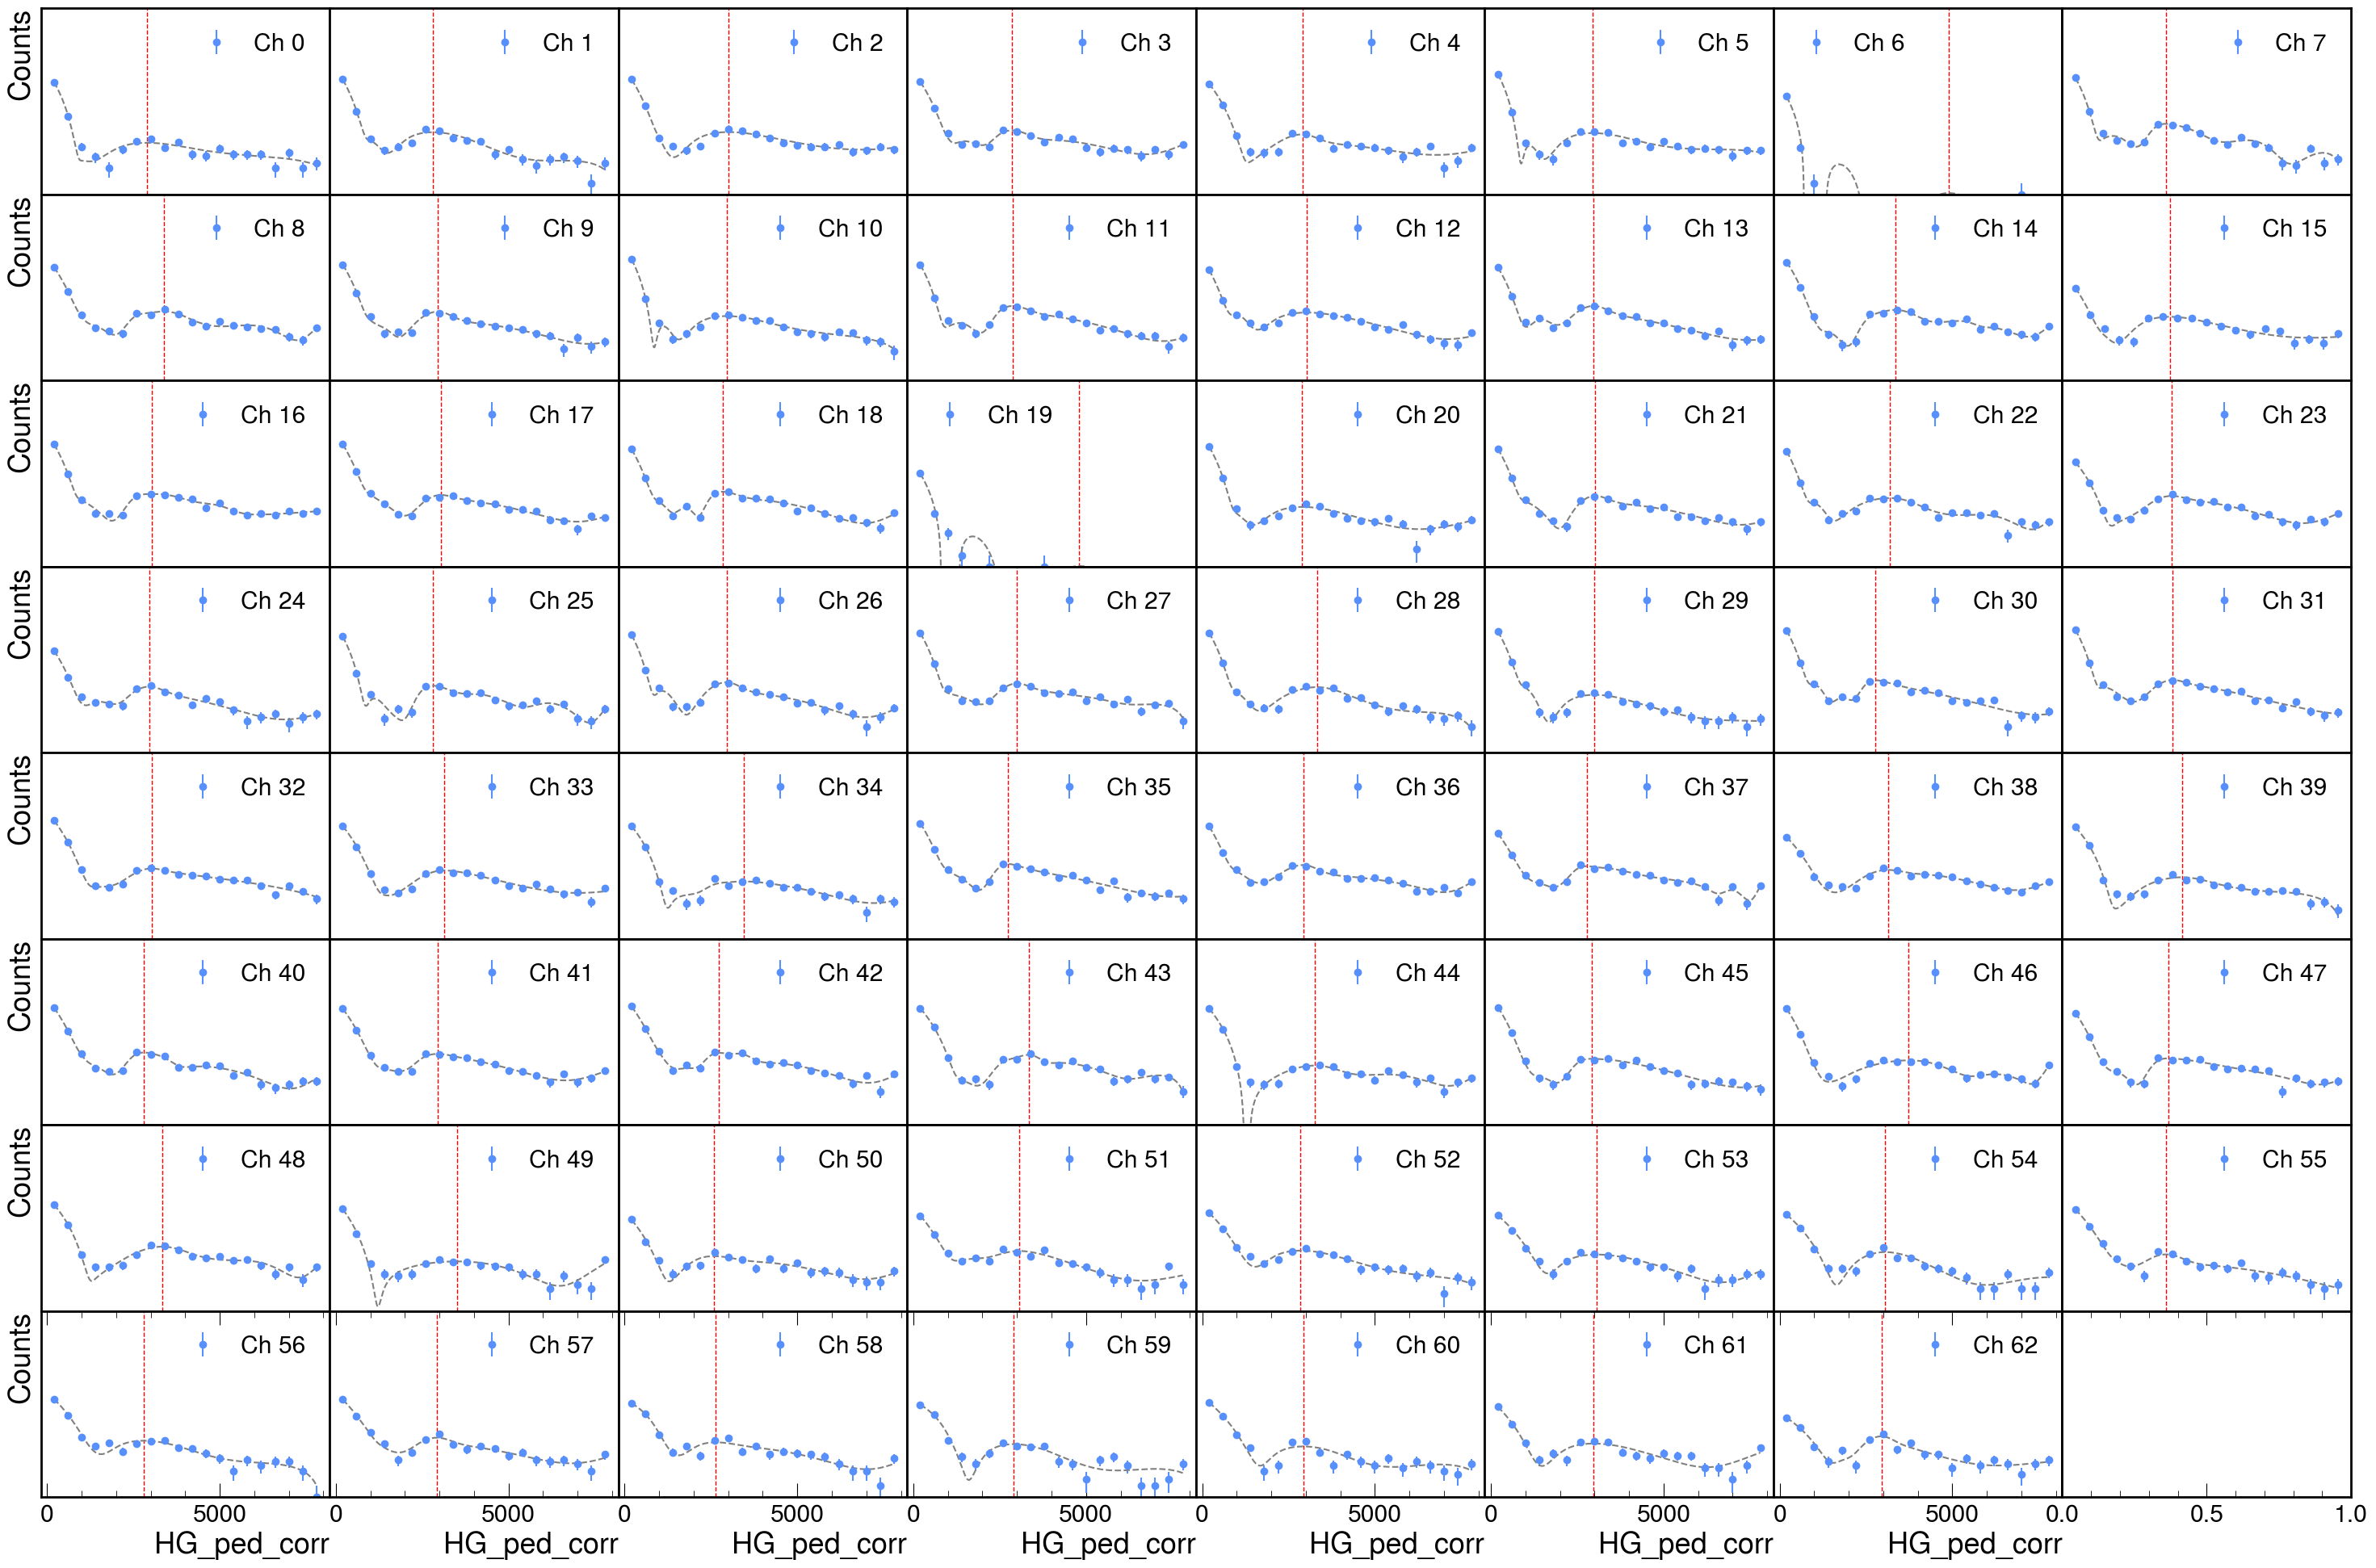

/var/folders/78/mghq7lpd3rbcbtn434kbwgdw0000gn/T/ipykernel_2559/2961455571.py:78: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=0.0)


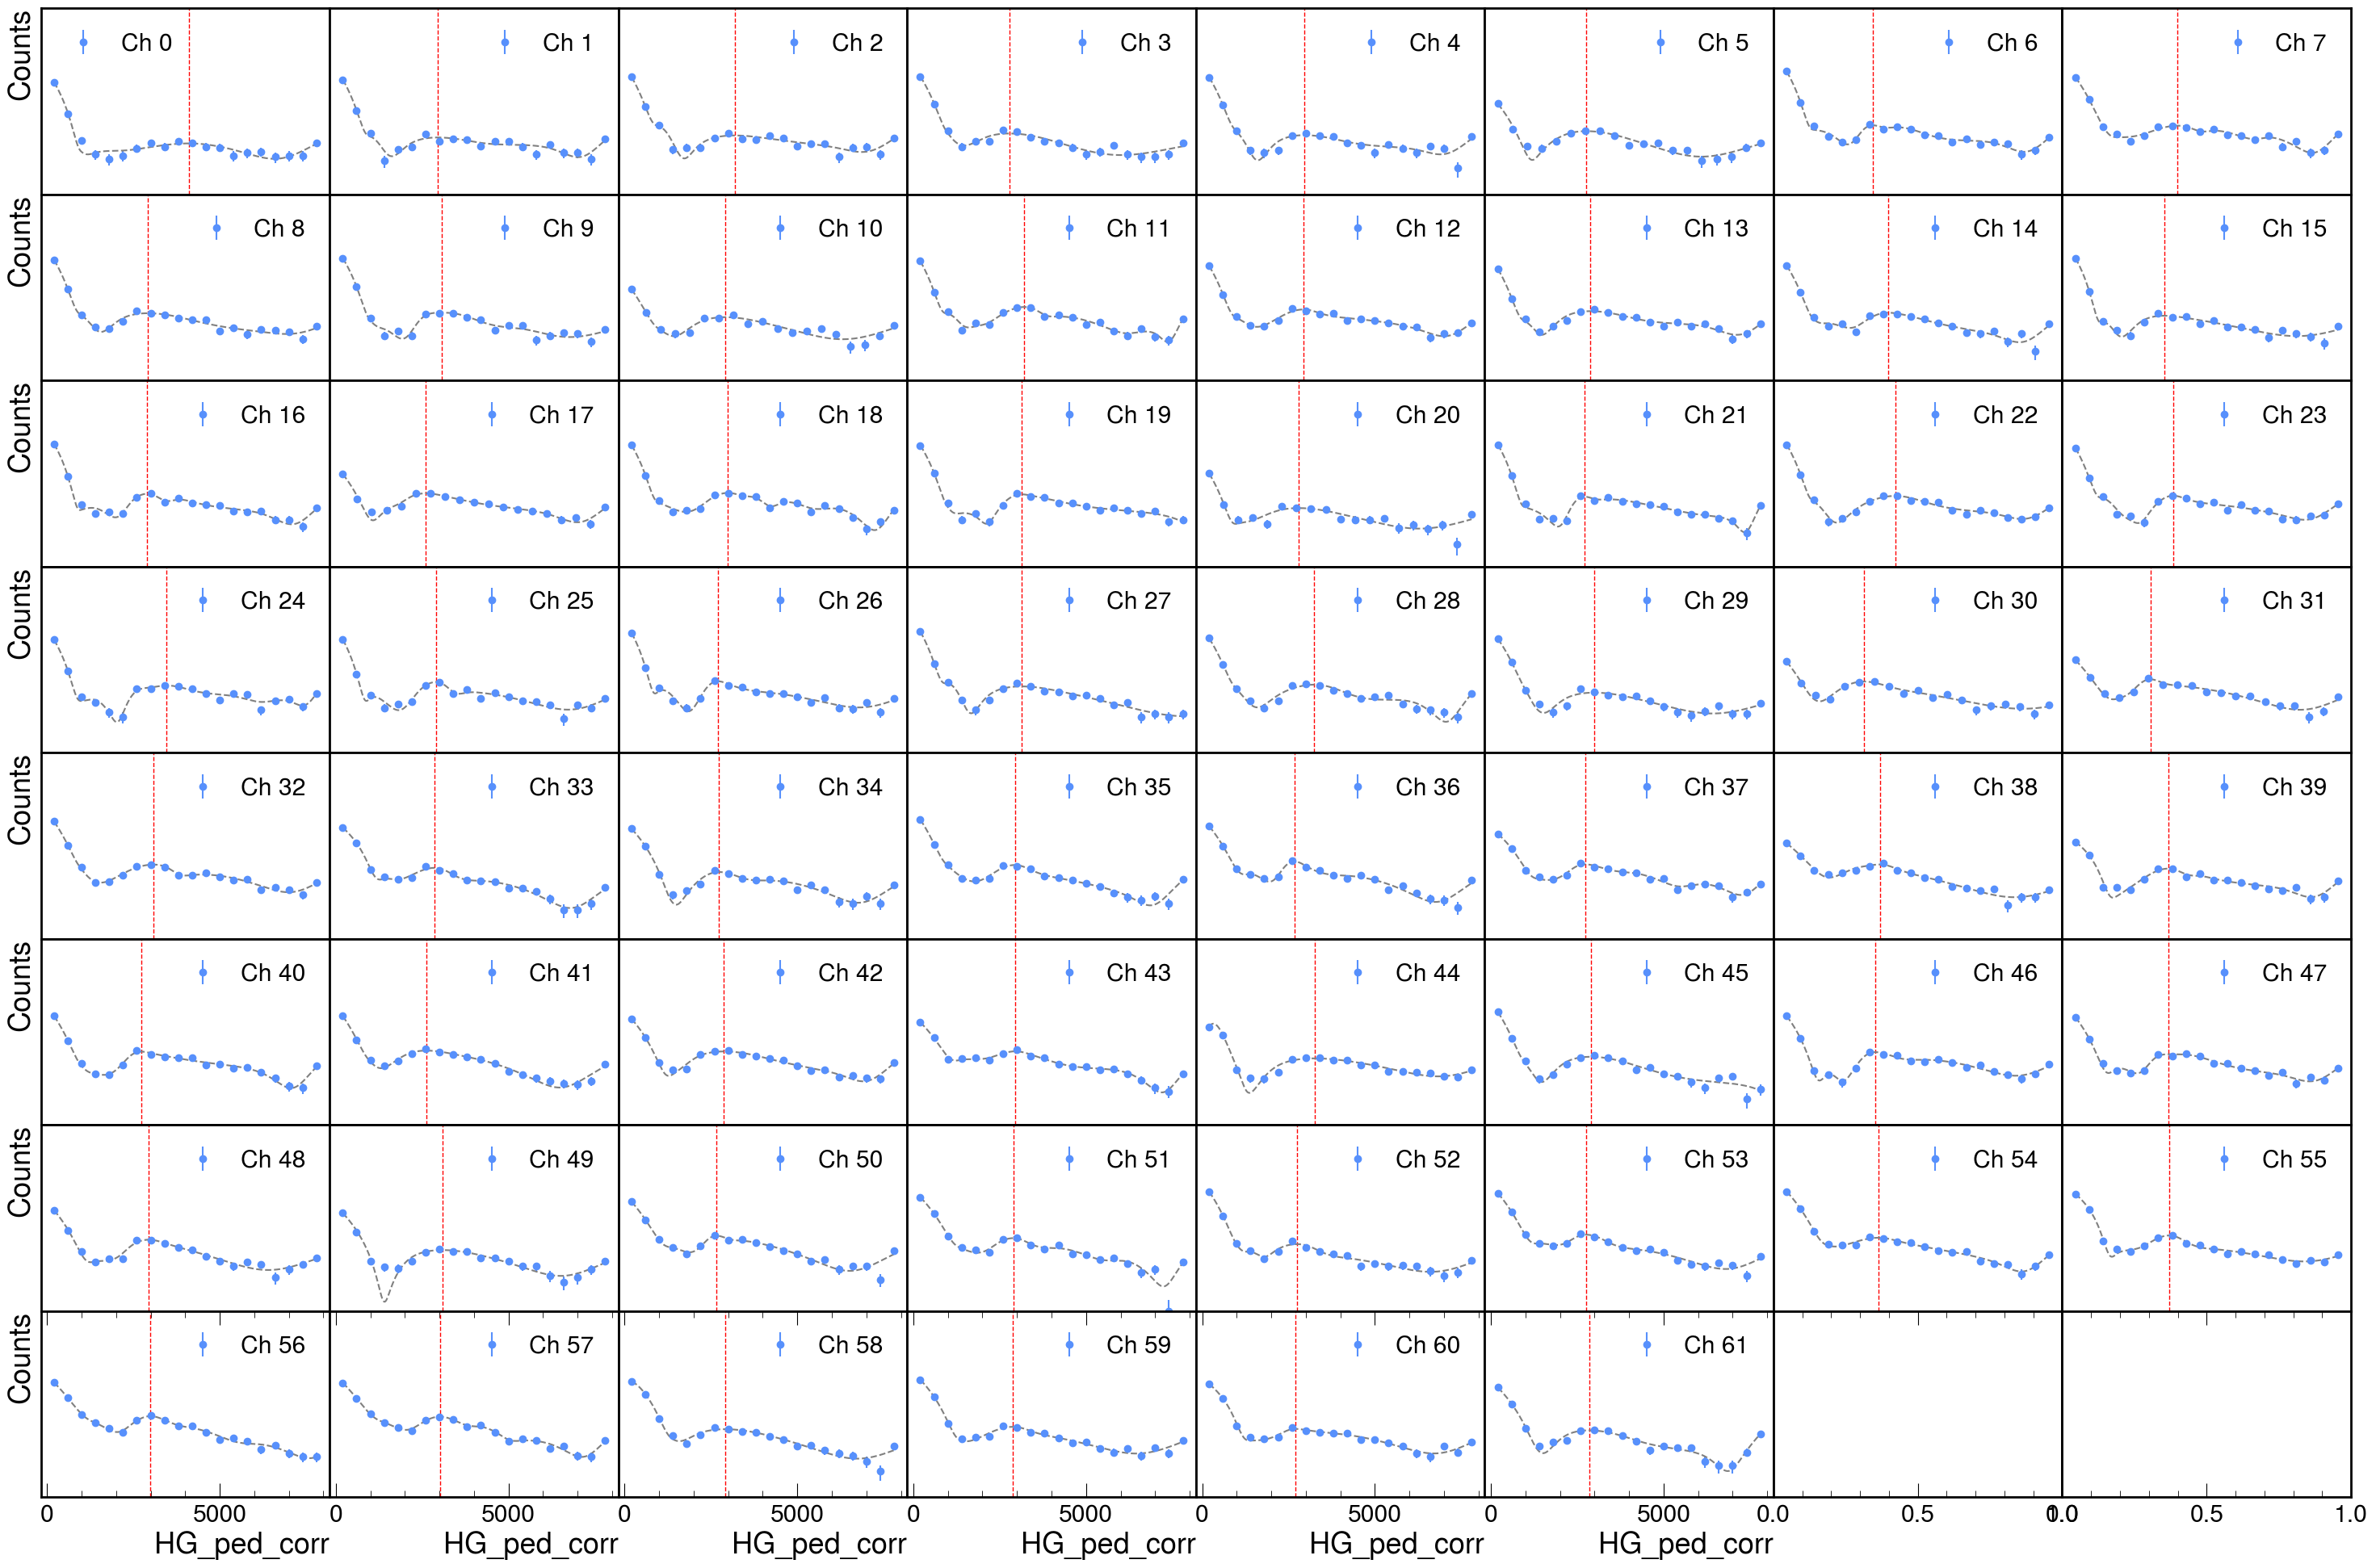

/var/folders/78/mghq7lpd3rbcbtn434kbwgdw0000gn/T/ipykernel_2559/2961455571.py:78: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=0.0)


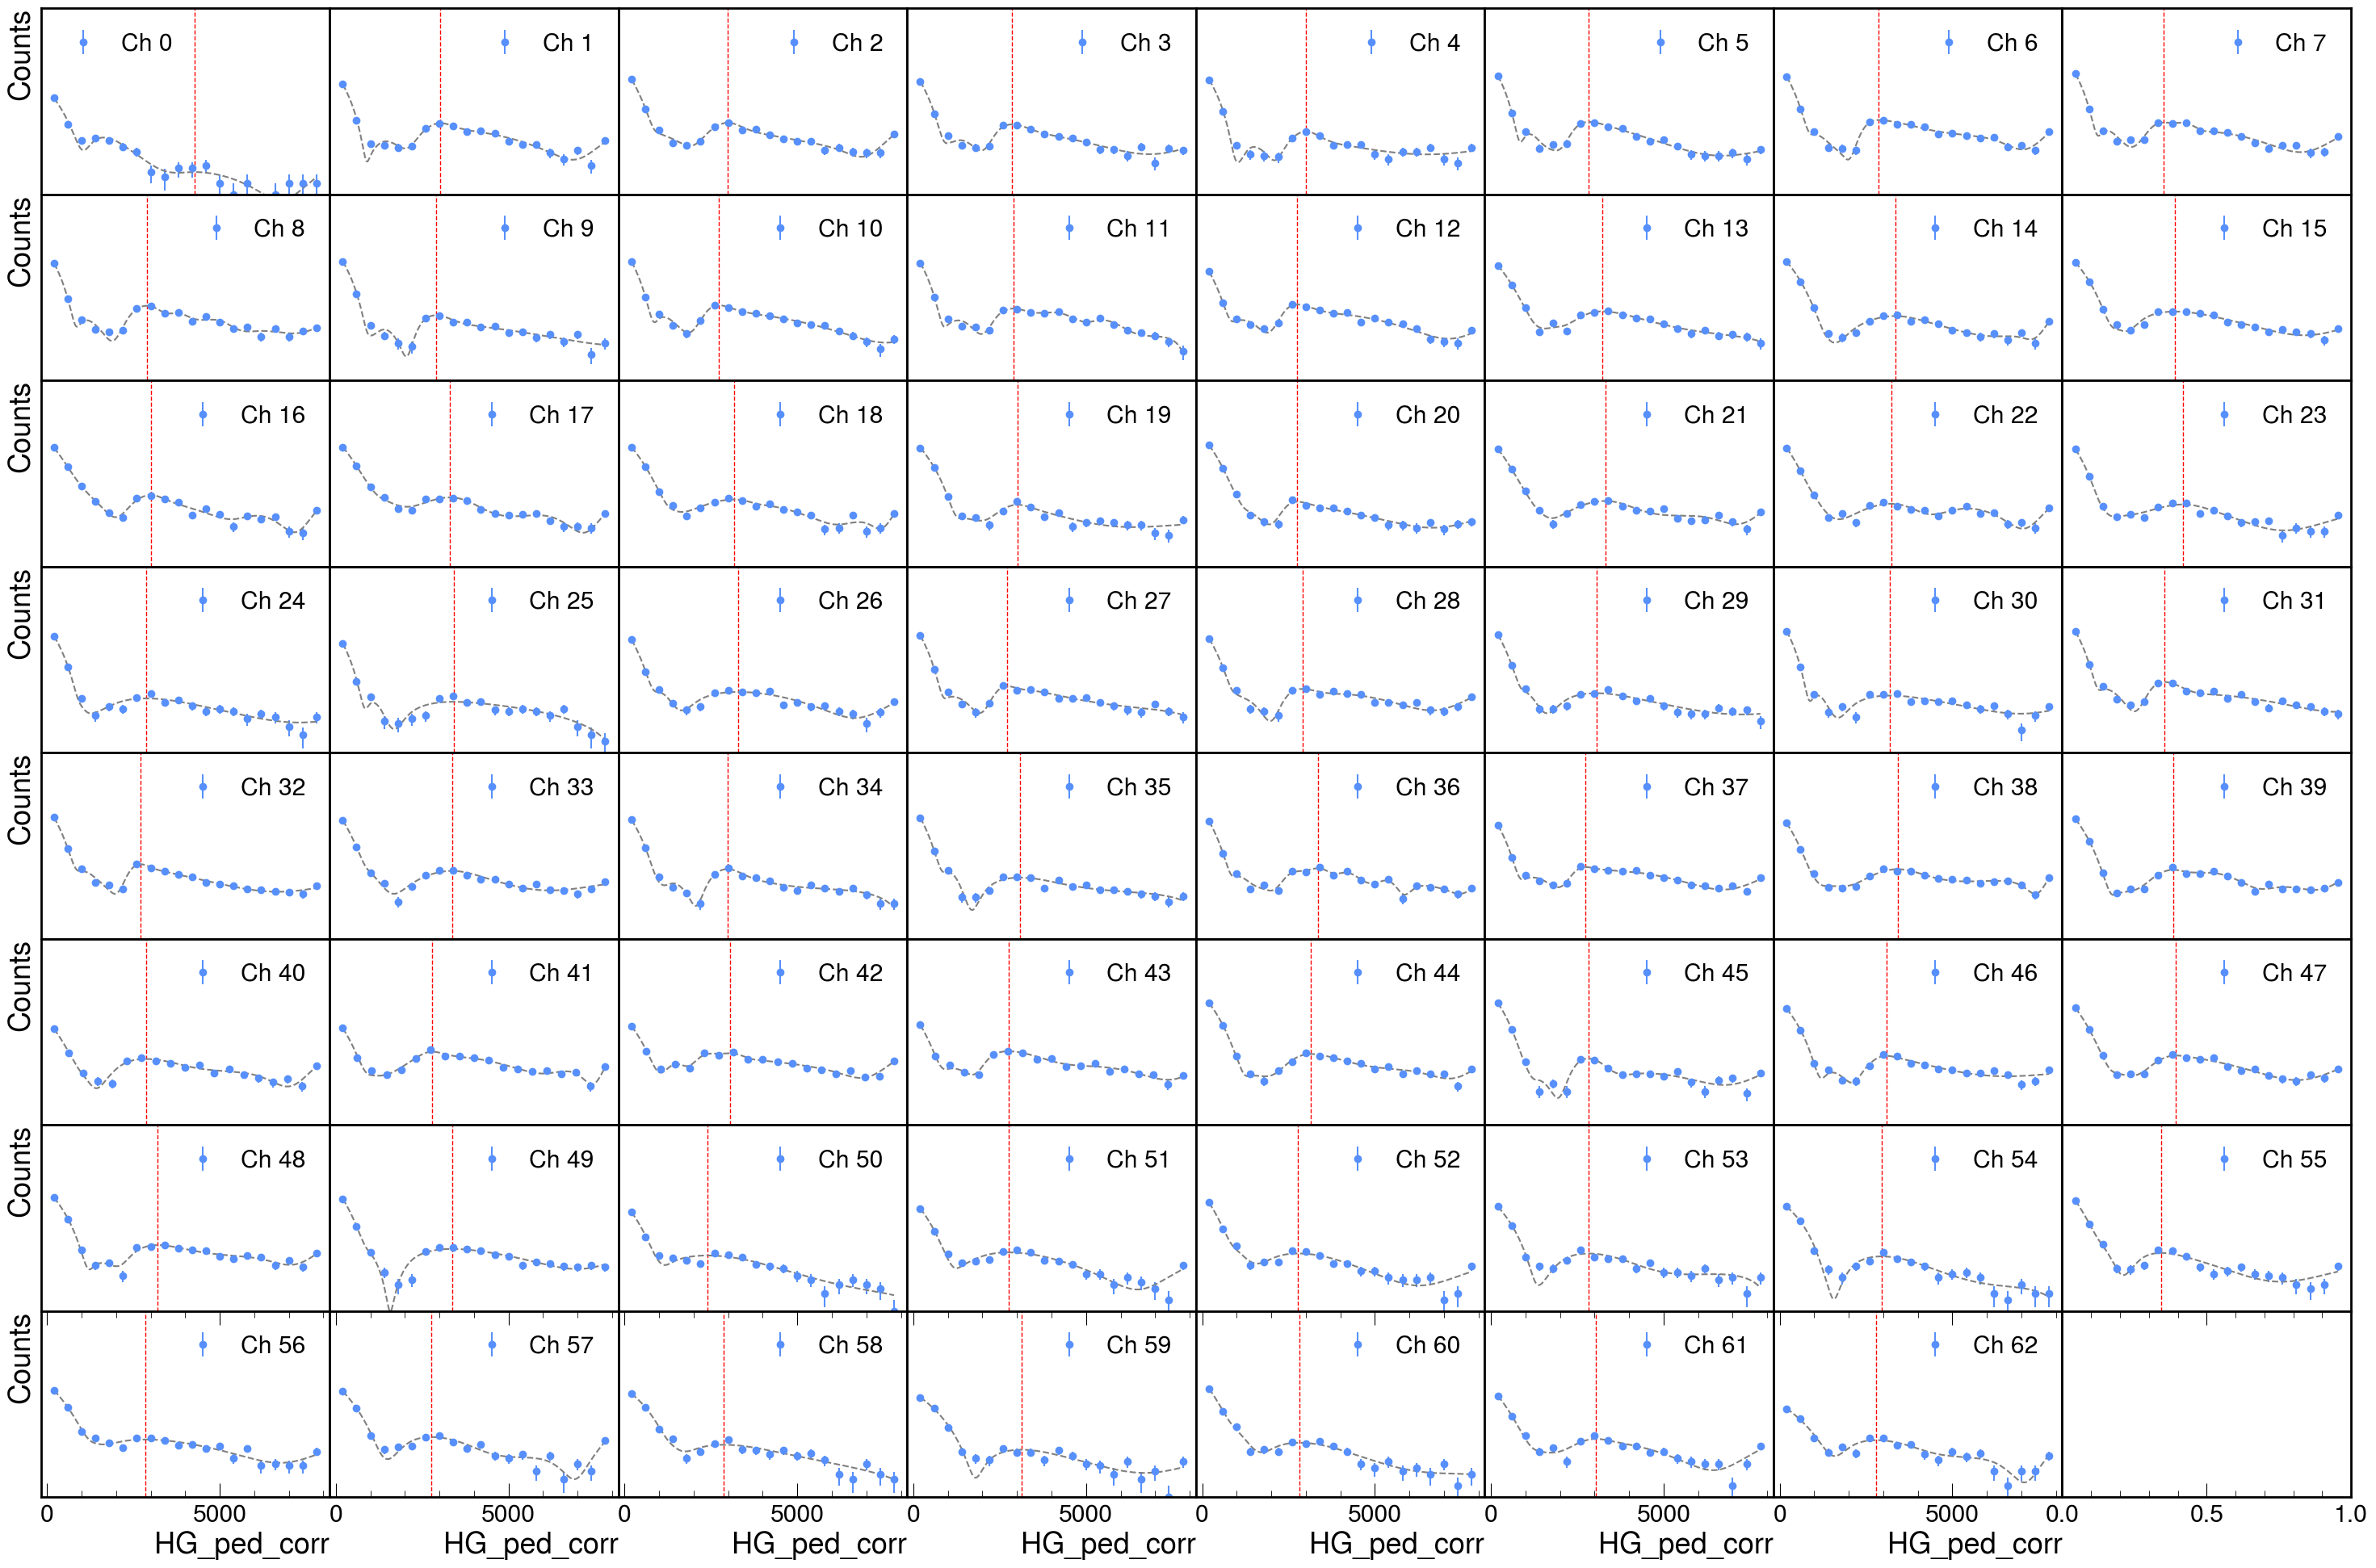

/var/folders/78/mghq7lpd3rbcbtn434kbwgdw0000gn/T/ipykernel_2559/2961455571.py:78: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=0.0)


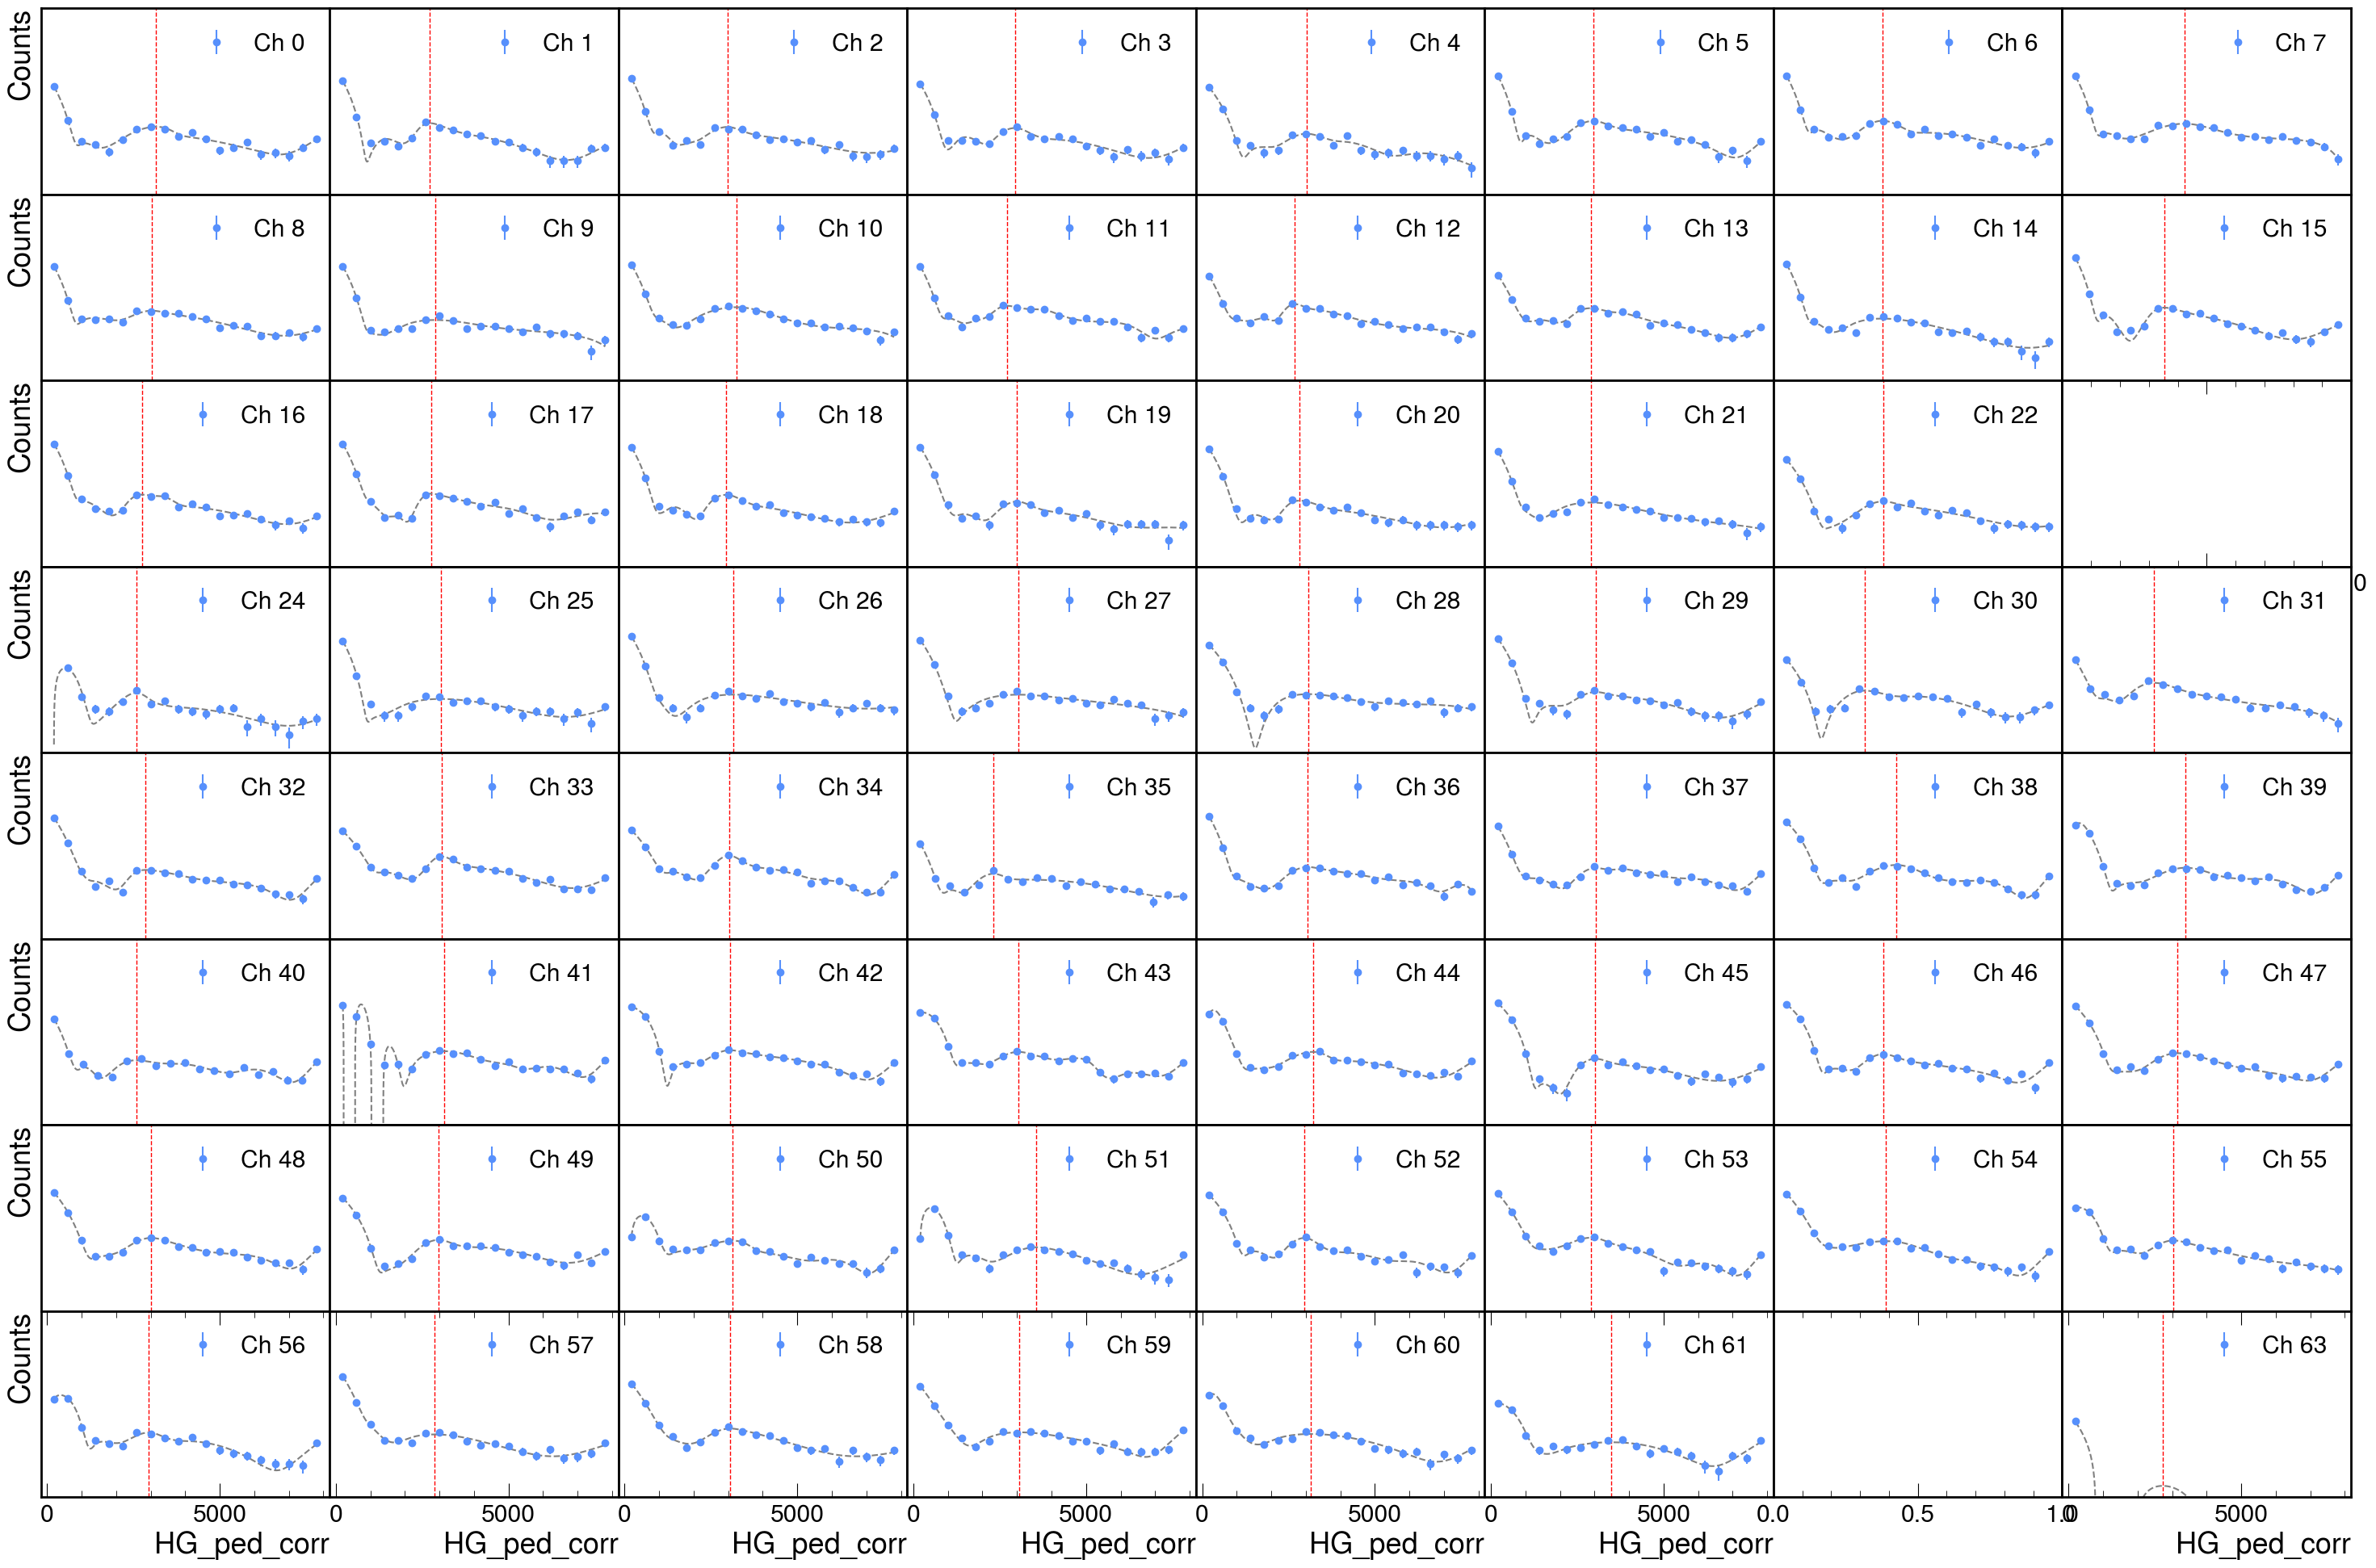

In [7]:
mip_peaks = []
for i in range(6):
    plot_mip_peaks_grid_for_caen(cosmic_df, i)

(0.0, 4000.0)

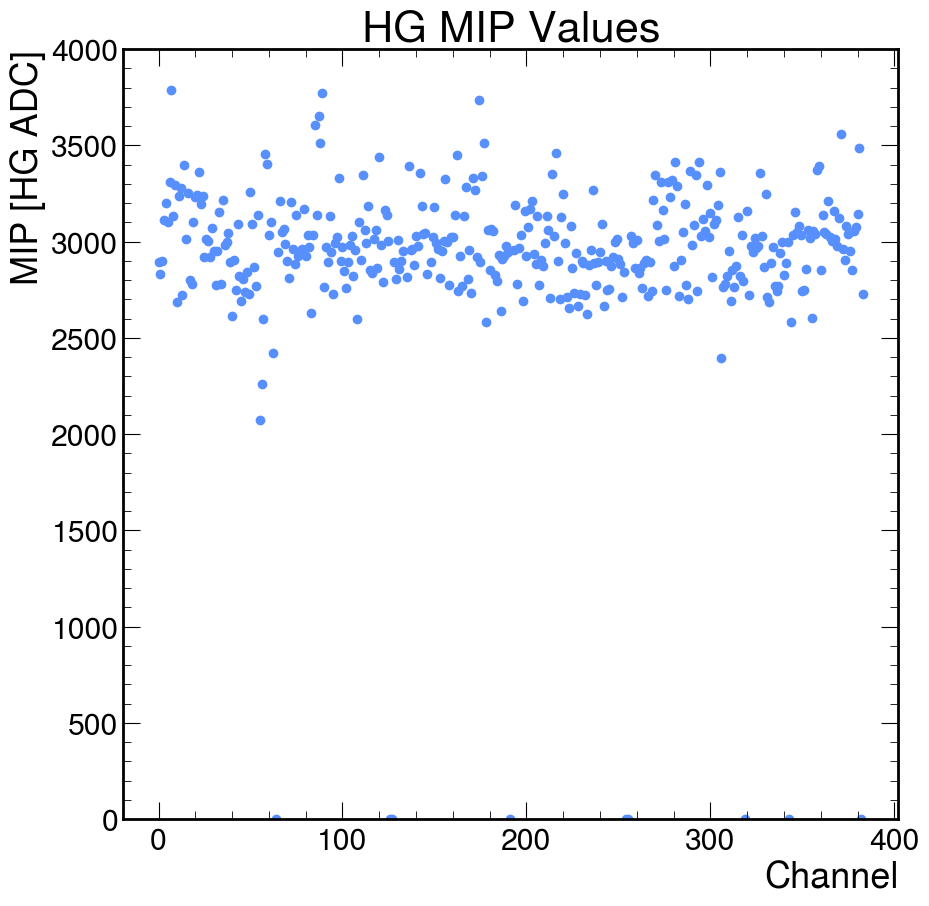

In [9]:
mip_peaks = np.array(mip_peaks)
#mask = (mip_peaks > 2500) & (mip_peaks < 3500)
#avg = np.mean(mip_peaks[mask])
#mip_peaks[~mask] = avg
plt.scatter(range(len(mip_peaks)), mip_peaks)
plt.xlabel("Channel")
plt.ylabel("MIP [HG ADC]")
plt.title("HG MIP Values")
plt.ylim(0, 4000)

In [13]:
mask = (mip_peaks > 2500) & (mip_peaks < 3500)
avg = np.mean(mip_peaks[mask])
mip_peaks[mip_peaks>0] = avg
print(avg)

2984.8522282395843


In [14]:
num_channels = len(mip_peaks)

# Calculate CAEN and CAEN_ch from channel index
channels = np.arange(num_channels)
CAEN = channels // 64
CAEN_ch = channels % 64

# Create dataframe
df_mip = pd.DataFrame({
    "channel": channels,
    "CAEN": CAEN,
    "CAEN_ch": CAEN_ch,
    "MIPs": mip_peaks
})

In [15]:
channels_to_zero = [63, 64, 112, 113, 125, 126, 127, 134, 147, 191, 254, 255, 319, 343, 382, 383]
df_mip.loc[df_mip["channel"].isin(channels_to_zero), "MIPs"] = 0


In [16]:
print(df_mip)

     channel  CAEN  CAEN_ch         MIPs
0          0     0        0  2984.852228
1          1     0        1  2984.852228
2          2     0        2  2984.852228
3          3     0        3  2984.852228
4          4     0        4  2984.852228
..       ...   ...      ...          ...
379      379     5       59  2984.852228
380      380     5       60  2984.852228
381      381     5       61  2984.852228
382      382     5       62     0.000000
383      383     5       63     0.000000

[384 rows x 4 columns]


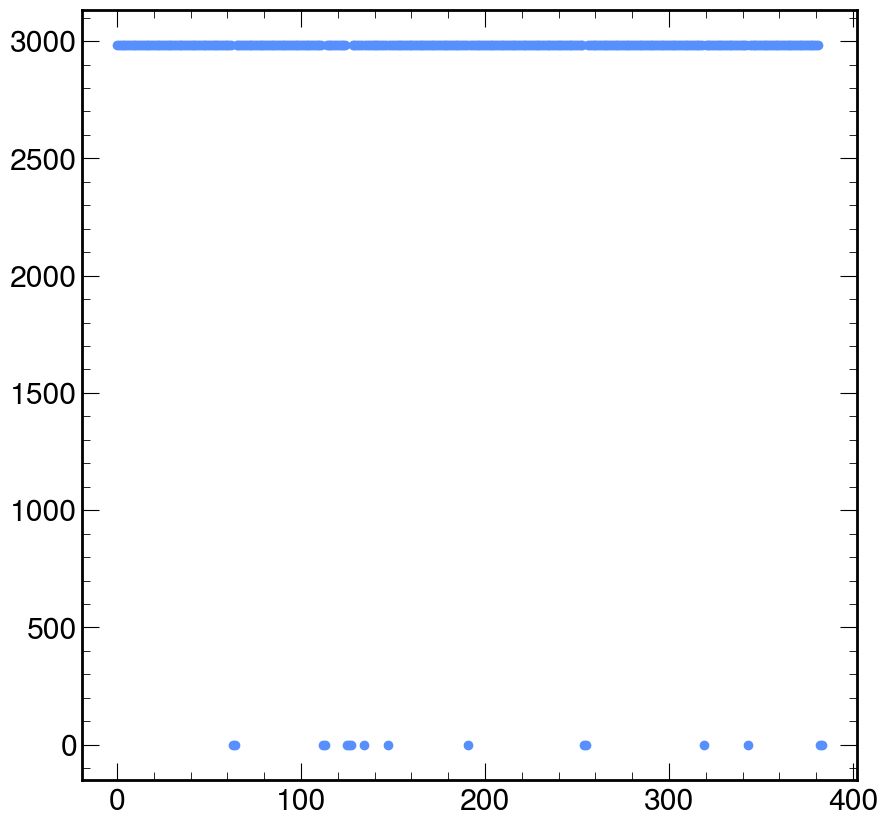

In [17]:
plt.scatter(range(len(mip_peaks)), np.array(df_mip["MIPs"]))

In [18]:
with open('MIP_avg_DF.pkl', 'wb') as f:
    pickle.dump(df_mip, f)